In [1]:
#Importing Packages
import numpy as np
import xarray as xr
from tinygp import kernels, GaussianProcess
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import create_levels,tinygp_2process_model,truth_posterior_predictive,bias_posterior_predictive,posterior_predictive_realisations
import geopandas as gpd
import cartopy.crs as ccrs

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [20]:
# Loading residual data
base_path = '/home/jez/Bias_Correction/'
nst_climate_residual_path = f'{base_path}data/ProcessedData/MetUM_Reformatted_Residual.nc'
obs_residual_path = f'{base_path}data/ProcessedData/NST_Observations_Reformatted_Residual.nc'

ds_obs_stacked = xr.open_dataset(obs_residual_path)
ds_climate = xr.open_dataset(nst_climate_residual_path)
ds_climate_stacked = ds_climate.stack(X=(('grid_longitude','grid_latitude'))).dropna('X','all')
ds_climate_stacked = ds_climate_stacked.where(ds_climate_stacked.lsm,drop=True)

rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)
antarctica_shapefile_path = f'{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp'
antarctica_gdf = gpd.read_file(antarctica_shapefile_path)
antarctica_gdf = antarctica_gdf.to_crs(rotated_coord_system)

obs_grid_longitudes = ds_obs_stacked.grid_longitude
obs_grid_latitudes = ds_obs_stacked.grid_latitude
ds_climate_nearest = ds_climate.sel(grid_longitude=obs_grid_longitudes,grid_latitude=obs_grid_latitudes,method='nearest')
da_difference_residual = ds_climate_nearest['Mean Jan Temperature Residual'] - ds_obs_stacked['Temperature Residual']
ds_obs_stacked['Difference Nearest Residual'] = (('Station_Lower'), da_difference_residual.data)

ox = jnp.vstack(
    [
        ds_obs_stacked.glon.data,
        ds_obs_stacked.glat.data,
    ]
).T  # shape = [sites,2]
odata = jnp.array(ds_obs_stacked['Temperature Residual'].data).T

ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<AxesSubplot: >

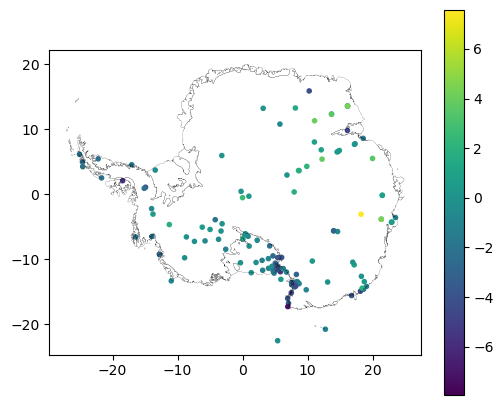

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
plot = axs.scatter(
    x=ds_obs_stacked.glon,y=ds_obs_stacked.glat,
    c=ds_obs_stacked['Difference Nearest Residual'])
plt.colorbar(plot)
antarctica_gdf.boundary.plot(ax=axs, color="k", linewidth=0.1)

sample: 100%|██████████| 6000/6000 [00:08<00:00, 720.99it/s, 7 steps of size 4.72e-01. acc. prob=0.87]  



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      data[0]     -0.01      3.22      0.04     -5.25      5.14   2540.61      1.00
      data[1]      0.00      3.22      0.03     -5.30      5.20   2499.54      1.00
     kern_var      6.02      3.38      5.36      0.96     10.90   3133.32      1.00
  lengthscale      6.01      3.39      5.43      1.11     10.92   4618.52      1.00
         mean     -0.00      2.04      0.05     -3.46      3.23   2400.22      1.00

Number of divergences: 21
Time Taken: 8.596020627766848


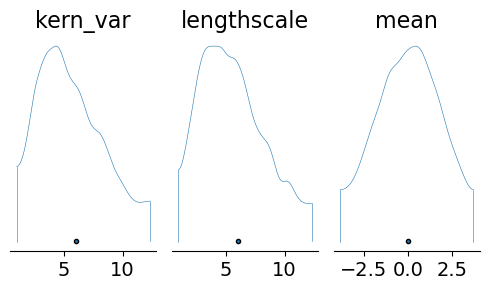

In [22]:
mcmc = run_inference(
    singleGP_model, rng_key_, 1000, 5000,
    ox[0])
idata = az.from_numpyro(mcmc).posterior.drop_vars('data')
az.plot_density(idata, figsize=(5, 3))
plt.tight_layout()
plt.show()

In [23]:
onoise = 1e-4
mcmc = run_inference(
    singleGP_model, rng_key_, 1000, 5000,
    ox,odata,onoise)

sample: 100%|██████████| 6000/6000 [00:46<00:00, 128.29it/s, 7 steps of size 6.63e-01. acc. prob=0.93]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      5.84      0.73      5.76      4.62      6.96   3886.51      1.00
  lengthscale      0.01      0.00      0.01      0.01      0.02   4224.71      1.00
         mean      0.93      0.21      0.93      0.60      1.27   4215.59      1.00

Number of divergences: 0
Time Taken: 48.568074345588684


In [24]:
onoise = 1e-1
mcmc = run_inference(
    singleGP_model, rng_key_, 1000, 2000,
    ox,odata,onoise)

sample: 100%|██████████| 3000/3000 [00:22<00:00, 134.18it/s, 3 steps of size 7.32e-01. acc. prob=0.92]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      5.76      0.76      5.71      4.62      7.04   1653.47      1.00
  lengthscale      0.02      0.01      0.02      0.01      0.03   1947.28      1.00
         mean      0.93      0.21      0.94      0.61      1.28   1598.61      1.00

Number of divergences: 0
Time Taken: 22.92826920002699


In [25]:
onoise = 1e1
mcmc = run_inference(
    singleGP_model, rng_key_, 1000, 2000,
    ox,odata,onoise)

sample: 100%|██████████| 3000/3000 [00:26<00:00, 111.68it/s, 3 steps of size 6.23e-01. acc. prob=0.92]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      3.60      2.04      3.16      0.73      6.60   1121.38      1.00
  lengthscale     10.12      4.15      9.77      3.34     16.16    994.29      1.00
         mean      0.96      0.85      0.93     -0.51      2.22   1198.53      1.00

Number of divergences: 0
Time Taken: 27.3066945374012


In [26]:
onoise = 1
mcmc = run_inference(
    singleGP_model, rng_key_, 1000, 2000,
    ox,odata,onoise)

sample: 100%|██████████| 3000/3000 [00:24<00:00, 123.21it/s, 3 steps of size 7.25e-01. acc. prob=0.91]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      6.64      1.37      6.47      4.33      8.55   1585.53      1.00
  lengthscale      1.92      0.31      1.92      1.43      2.44   1339.83      1.00
         mean      0.72      0.42      0.71      0.03      1.38   1371.39      1.00

Number of divergences: 0
Time Taken: 24.984891891479492
